In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('./fulldata.csv')
df.head()

,Unnamed: 0,sp,word,round,order,Label,duration,timepoint,pF0_means,vqual,...,f0ST_means,vowelqual,f0ST_means_scaled,H1c_means_scaled,H1H2c_means_scaled,H1A1c_means_scaled,H1A2c_means_scaled,H1A3c_means_scaled,CPP_means_scaled,pF1_means_scaled
0,1,1,beard,1,49,uuH,125.892,1,240.535,breathy,...,27.194962,uu,0.303746,0.098379,0.137656,-0.085678,-0.005704,-0.406845,-0.421461,-1.133266
1,2,1,beard,2,6,uuH,107.982,1,247.509,breathy,...,27.689772,uu,0.355746,0.232261,0.097359,0.001183,0.095708,-0.390805,-0.515863,-1.237534
2,3,1,beard,3,33,uuH,142.940,1,244.426,breathy,...,27.472773,uu,0.332942,0.274019,0.107324,-0.109050,0.023509,-0.219512,-0.752780,-1.417865
3,4,1,beard,4,22,uuH,133.586,1,239.742,breathy,...,27.137792,uu,0.297738,0.236043,0.114589,-0.160673,0.036078,-0.488220,-0.255802,-1.504129
4,5,1,beard,5,50,uuH,160.248,1,246.624,breathy,...,27.627758,uu,0.349229,0.307570,0.076158,0.075996,-0.031587,-0.677209,-0.756971,-1.329145


The next cells reshape the data so that all of the data from a single production is in a single row.  At the same time, I'll make the factors a little easier to read.

In [3]:
factors = ['f0ST_means_scaled', 'H1c_means_scaled', 'H1H2c_means_scaled',
       'H1A1c_means_scaled', 'H1A2c_means_scaled', 'H1A3c_means_scaled',
       'CPP_means_scaled', 'pF1_means_scaled']
factors_short = ['f0', 'H1c', 'H1H2c',
       'H1A1c', 'H1A2c', 'H1A3c',
       'CPP', 'F1']

In [4]:
t = df[df.timepoint==1][['sp','word','round','order','Label','duration', 'vowelqual', 'vqual', 'coda', 'onset']+factors]
t = t.rename(columns={"f0ST_means_scaled":"f0_2", "H1c_means_scaled":"H1c_2", "H1H2c_means_scaled":"H1H2c_2",
                 "H1A1c_means_scaled":"H1A1c_2", "H1A2c_means_scaled":"H1A2c_2", "H1A3c_means_scaled":"H1A3c_2",
                 "CPP_means_scaled":"CPP_2", "pF1_means_scaled":"F1_2"})

# this reduces the number of timepoints from 20 to 5, just to make things more manageable
for i in range(2,6):
    tmp = df[df.timepoint==4*i-2][['sp','word','round','order']+factors]
    tmp.columns = ['sp','word','round','order']+[f+'_'+str(4*i-2) for f in factors_short]
    t = t.merge(tmp)
    
t.head()

,sp,word,round,order,Label,duration,vowelqual,vqual,coda,onset,...,CPP_14,F1_14,f0_18,H1c_18,H1H2c_18,H1A1c_18,H1A2c_18,H1A3c_18,CPP_18,F1_18
0,1,beard,1,49,uuH,125.892,uu,breathy,ʔ,p,...,-0.076839,0.378678,0.313914,-0.057147,0.200582,-0.170612,-0.041287,-0.304897,-0.233386,0.087034
1,1,beard,2,6,uuH,107.982,uu,breathy,ʔ,p,...,-0.321227,0.010898,0.298155,0.151401,0.259380,-0.271929,0.203834,-0.139793,-0.548120,0.194618
2,1,beard,3,33,uuH,142.940,uu,breathy,ʔ,p,...,-0.466111,0.628524,0.400459,0.170309,0.289950,0.147256,0.006636,-0.431035,-0.814924,0.162140
3,1,beard,4,22,uuH,133.586,uu,breathy,ʔ,p,...,0.184863,0.371101,0.341111,0.170711,0.416995,-0.343310,-0.061374,-0.590952,-0.411438,0.517678
4,1,beard,5,50,uuH,160.248,uu,breathy,ʔ,p,...,-0.682069,0.372143,0.477850,-0.048940,0.006324,0.164424,-0.816823,-0.776541,-0.893836,0.268215


This function takes in some data (x) and labels (y), trains an LDA on that data, then tests its accuracy using the same data.

In [5]:
def lda_acc(x, y):
    lda = LDA()
    X_train = lda.fit_transform(x,y)
    y_pred = lda.predict(x)

    return accuracy_score(y, y_pred)

For each speaker, do the following:
1. Split the acoustic data into three sets: the full acoustics, only f0 information, and only voice quality information
1. Run the LDA over each set of data
1. Save the accuracy results in a dataframe

In [6]:
acc_f0 = []
acc_nof0 = []
acc_all = []

for s in t.sp.unique():
    tsub = t[t.sp==s].dropna(axis='rows')
    
    x = tsub.iloc[:,10:]
    y = tsub.iloc[:,:10]
    
    f0_only = x.iloc[:,[0,8,16,24,32]]
    nof0 = x.drop(['f0_2','f0_6','f0_10','f0_14','f0_18','F1_2','F1_6','F1_10','F1_14','F1_18'], axis=1)
    full = pd.concat([f0_only,nof0], axis=1)

    acc_f0 = acc_f0+[lda_acc(f0_only, y.vqual)]
    acc_nof0 = acc_nof0+[lda_acc(nof0, y.vqual)]
    acc_all = acc_all+[lda_acc(x, y.vqual)]

resultsdf = pd.DataFrame({'sp':t.sp.unique(),'f0only':acc_f0, 'nof0':acc_nof0, 'full':acc_all})
resultsdf.head()

,sp,f0only,nof0,full
0,1,0.780000,0.950000,0.980000
1,10,0.720588,0.985294,0.992647
2,11,0.692308,0.990385,1.000000
3,12,0.894737,1.000000,1.000000
4,13,0.750000,0.942308,0.980769


Get the demographic info from the main dataframe (kind of kludgey but got the job done), and join it up with the results.

In [7]:
socialdf = df.groupby(['sp','age','decade','gender','yearsaway','experiencePC','famPC','awayPC',
                       'idPC']).mean().reset_index().iloc[:,:9].groupby(['sp','gender']).mean().reset_index()

In [8]:
resultsdf = socialdf.merge(resultsdf)

In [9]:
pd.options.display.max_rows = 999
resultsdf

,sp,gender,age,decade,yearsaway,experiencePC,famPC,awayPC,idPC,f0only,nof0,full
0,1,f,31,30,7.0,-1.043926,-0.228534,0.811728,-0.218302,0.780000,0.950000,0.980000
1,2,m,34,30,0.0,-0.779533,0.750860,-1.048702,-0.590100,0.863636,0.981818,0.981818
2,3,m,50,50,0.0,0.129850,0.502381,-1.470801,1.373952,0.935065,1.000000,1.000000
3,4,m,27,20,3.0,-0.097690,1.413516,0.412594,-1.076652,0.688889,1.000000,1.000000
4,5,f,22,20,0.0,-2.169840,-0.106268,-1.211306,0.058194,0.738636,0.977273,1.000000
5,6,f,54,50,9.0,2.602203,-0.180238,1.267120,-0.971911,0.770115,0.988506,1.000000
6,7,f,52,50,5.0,-0.606313,-1.088168,-0.571741,0.101889,0.946429,1.000000,1.000000
7,10,m,22,20,4.0,-0.160414,1.947177,1.225265,0.596070,0.720588,0.985294,0.992647
8,11,f,59,50,0.0,0.984196,-1.463614,-2.187141,-2.056475,0.692308,0.990385,1.000000
9,12,f,53,50,23.0,1.634058,0.419214,1.524118,-1.037608,0.894737,1.000000,1.000000


This figure shows that overall, all speakers use voice quality acoustic cues (nof0) in their contrast between breathy and modal, and that no speaker usees f0 (f0only) cues to the same extent or more than they use voice quality cues.  This figure also shows that all the same, younger speakers tend to be more likely to use f0 to _some_ extent for signaling the breathy/modal contrast.

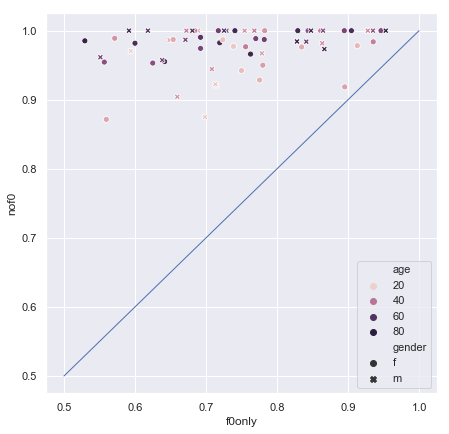

In [10]:
sns.set(rc={'figure.figsize':(7,7)})
splot = sns.scatterplot(x='f0only',y='nof0',hue='age',style='gender',data=resultsdf)
plt.plot([0.5, 1], [0.5, 1], linewidth=1)